In [1]:
import dlc_practical_prologue as prologue
#Sometimes download directly will have http403 error
from six.moves import urllib

In [2]:
import torch
import time
import numpy as np
from torch import nn
from torch.nn import functional as F
import torchvision
from torch.autograd import Variable
import matplotlib.pyplot as plt

In [3]:
# sometimes download directly will have the http403 error. If that happen, then use this code.
# have to add a header to your urllib request (due to that site moving to Cloudflare protection)
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)
#*********************** 

In [4]:
# load data
N_PAIRS = 1000
train_input, train_target, train_classes, test_input, test_target, test_classes = prologue.generate_pair_sets(N_PAIRS)

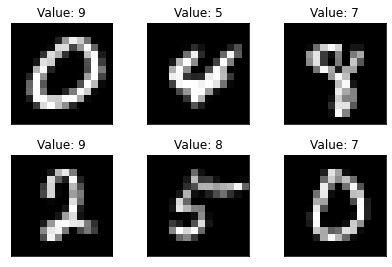

In [5]:
# displaying samples of data
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.imshow(test_input[i][0], cmap='gray')
  plt.title("Value: {}".format(train_classes[i][0]))  
  plt.tight_layout()
  plt.xticks([])
  plt.yticks([])

In [6]:
# understand the data of the training and testing data
print(train_input.shape)
print(train_input.dtype)
print(train_target.shape)
print(train_target.dtype)
print(train_classes.shape)
print(test_classes.shape)
print(train_classes[0])

torch.Size([1000, 2, 14, 14])
torch.float32
torch.Size([1000])
torch.int64
torch.Size([1000, 2])
torch.Size([1000, 2])
tensor([9, 3])


In [7]:
#weights_sharing_CNN
# What the weight sharing does is using both the 2000 images together to train the same layer, 
# which will be better than purely using 1000 images
class CNN_Net_weight_sharing_auxiliary_loss(nn.Module):
    def __init__(self):
        super(CNN_Net_weight_sharing_auxiliary_loss, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=5)
        self.conv2 = nn.Conv2d(64,128,kernel_size=2)
        self.conv2_drop=nn.Dropout2d()
        self.fc1 = nn.Linear(512, 128)
        self.fc2 = nn.Linear(128, 10)
        self.fc3 = nn.Linear(20,200)
        self.fc4 = nn.Linear(200,200)
        self.fc5 = nn.Linear(200,2)
        #parameters
        self.batch_size = 50
        self.criterion = nn.CrossEntropyLoss()
        self.num_epochs = 25
        self.optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)

    def forward(self, x):
#         print(x.shape)
        img1 = x[:,0,:,:].view(-1,1,14,14)
        img2 = x[:,1,:,:].view(-1,1,14,14)
        
        
        # weight sharing
        img1 = F.relu(F.max_pool2d(self.conv1(img1), kernel_size=2, stride=2))
        img1 = F.relu(F.max_pool2d(self.conv2(img1), kernel_size=2, stride=2))
        img2 = F.relu(F.max_pool2d(self.conv1(img2), kernel_size=2, stride=2))
        img2 = F.relu(F.max_pool2d(self.conv2(img2), kernel_size=2, stride=2))

#       detect the img1 figure 
        output1 = img1.view(-1,512)
        output1 = F.relu(self.fc1(output1))
        output1 = self.fc2(output1)
#       detect the img2 figure
        output2 = img2.view(-1,512)
        output2 = F.relu(self.fc1(output2))
        output2 = self.fc2(output2)

        output = torch.cat((output1,output2),1)      
        output = F.relu(self.fc3(output))
        output = F.relu(self.fc4(output))
        output = self.fc5(output)
        
        return output, output1, output2

        # Training Function with auxiliary_loss

    def trainer(self, train_input, train_target, train_classes, test_input, test_target, test_classes):
        """
        Train the model on a training set
        :param train_input: Training features
        :param train_target: Training labels
        :param train_classes: Training classes
        :param test_input: Testing features
        :param test_target: Training labels
        :output the loss plot
        """
        start_time = time.time()
#         self.train()
        train_loss_history=[]
        test_loss_history=[]
        train_accuracy=[]
        test_accuracy=[]
        for epoch in range(self.num_epochs):
            # train mode
            self.train()
            for batch_idx in range(0,train_input.size(0),self.batch_size):
                output, output1, output2 = self(train_input[batch_idx:batch_idx+self.batch_size])
#                 output = self(train_input[batch_idx:batch_idx+self.batch_size])
                target = train_target[batch_idx:batch_idx+self.batch_size]
#                 print(output.shape)
#                 print(target.shape)
                class1 = train_classes[batch_idx:batch_idx+self.batch_size,0]
                class2 = train_classes[batch_idx:batch_idx+self.batch_size,1]
                loss = self.criterion(output, target)+0.5*self.criterion(output1, class1)+0.5*self.criterion(output2, class2)
                #gradients to zero
                self.optimizer.zero_grad()                          
                #backpropagation
                loss.backward() 
                self.optimizer.step()         
#                 every 50 batch_idx, output the loss
                if not batch_idx % 50:
                    print ('Epoch: %03d/%03d | Batch %03d/%03d | Loss: %.6f' 
                           %(epoch+1, self.num_epochs, batch_idx, 
                             len(train_input), loss))
            # test mode
            self.eval()
            # get the training loss and accuracy
            train_predicted, train_output1, train_output2 = self(train_input)
            train_loss = self.criterion(train_predicted, train_target)+0.5*self.criterion(train_output1, train_classes[:,0])+0.5*self.criterion(train_output2, train_classes[:,1])
            train_loss_history.append(train_loss)
            _, train_pred = torch.max(train_predicted, 1)   #return the index of the bigger result
            train_accuracy_result=self.compute_accuracy(train_target,train_pred)
            train_accuracy.append(train_accuracy_result)

            # get the testing loss and accuracy
            test_predicted, test_output1, test_output2 = self(test_input)
            test_loss = self.criterion(test_predicted, test_target)+0.5*self.criterion(test_output1, test_classes[:,0])+0.5*self.criterion(test_output2, test_classes[:,1])
            test_loss_history.append(test_loss)
            _, test_pred = torch.max(test_predicted, 1)   #return the index of the bigger result
            test_accuracy_result=self.compute_accuracy(test_target,test_pred)
            test_accuracy.append(test_accuracy_result)
            
            
            print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

        print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))
        
        # plot the accuracy and loss figure
            #Plotting the train and test loss and accuracy figure

        #Setting-up the plot
        plt.figure(figsize=(15,8))

        ax1 = plt.subplot(1,2,1)

        ax2 = plt.subplot(1,2,2)

        #Drawing and labeling the curves
        ax1.plot(train_loss_history, label="Training Loss")
        ax1.plot(test_loss_history, label="Test Loss")

        #Adding the title and axis labels
        ax1.set_title('Train VS Test Loss')
        ax1.set_ylabel('Loss')
        ax1.set_xlabel('Epoch')
        ax1.legend()

    #     #Saving the plot
    #     ax1.figure.savefig(model.model_name+'loss.png')


        #Drawing and labeling the curves
        ax2.plot(train_accuracy, label="Train Accuracy")
        ax2.plot(test_accuracy, label="Test Accuracy")

        #Adding the title and axis labels
        ax2.set_title('Train VS Test Accuracy')
        ax2.set_ylabel('Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.legend()

        #Saving the plot
    #     ax2.figure.savefig(model.model_name+'accuracy.png')
        plt.savefig('accuracy_loss.png')

        # Test error

    def compute_error(self, input_data, target):
        """
        Compute the number of error of the model on a test set with batch_size
        :param input_data: test features
        :param target: test target
        :return: error rate of the input data
        """  
    
        #test mode
        self.eval()
        outputs,_,_ = self(input_data)
        _, predicted = torch.max(outputs, 1)
        return 1-self.compute_accuracy(target,predicted)

    def compute_accuracy(self, target, pred):
        """
        Compute the training and testing error
        :param target: target data (whether 1 or 0)
        :param pred: predicted data
        :return 
        """
        return (target-pred).eq(0).float().mean().item()
    
    def save_model(self,model_name):
        """
        Save the model to a direction
        :param model_name: the model name, e.g. CNN_Net.pth
        :output the model pth.
        """         
        torch.save(self, './model/'+ model_name)

In [8]:
# build an net instance
my_model=CNN_Net_weight_sharing_auxiliary_loss()
# save the model
my_model.save_model('CNN_Net_weight_sharing_auxiliary_loss.pth')

Epoch: 001/025 | Batch 000/1000 | Loss: 16.140072
Epoch: 001/025 | Batch 050/1000 | Loss: 14.284233
Epoch: 001/025 | Batch 100/1000 | Loss: 13.604460
Epoch: 001/025 | Batch 150/1000 | Loss: 12.520069
Epoch: 001/025 | Batch 200/1000 | Loss: 11.728791
Epoch: 001/025 | Batch 250/1000 | Loss: 9.136544
Epoch: 001/025 | Batch 300/1000 | Loss: 8.912584
Epoch: 001/025 | Batch 350/1000 | Loss: 8.576550
Epoch: 001/025 | Batch 400/1000 | Loss: 8.552234
Epoch: 001/025 | Batch 450/1000 | Loss: 7.109972
Epoch: 001/025 | Batch 500/1000 | Loss: 6.873606
Epoch: 001/025 | Batch 550/1000 | Loss: 6.474693
Epoch: 001/025 | Batch 600/1000 | Loss: 5.971671
Epoch: 001/025 | Batch 650/1000 | Loss: 5.262382
Epoch: 001/025 | Batch 700/1000 | Loss: 5.179395
Epoch: 001/025 | Batch 750/1000 | Loss: 5.403171
Epoch: 001/025 | Batch 800/1000 | Loss: 4.920031
Epoch: 001/025 | Batch 850/1000 | Loss: 4.499071
Epoch: 001/025 | Batch 900/1000 | Loss: 4.134079
Epoch: 001/025 | Batch 950/1000 | Loss: 4.752315
Time elapsed: 0

Epoch: 009/025 | Batch 350/1000 | Loss: 0.587040
Epoch: 009/025 | Batch 400/1000 | Loss: 0.698955
Epoch: 009/025 | Batch 450/1000 | Loss: 0.758941
Epoch: 009/025 | Batch 500/1000 | Loss: 0.664380
Epoch: 009/025 | Batch 550/1000 | Loss: 0.700143
Epoch: 009/025 | Batch 600/1000 | Loss: 0.658229
Epoch: 009/025 | Batch 650/1000 | Loss: 0.464526
Epoch: 009/025 | Batch 700/1000 | Loss: 0.752912
Epoch: 009/025 | Batch 750/1000 | Loss: 0.618402
Epoch: 009/025 | Batch 800/1000 | Loss: 0.483868
Epoch: 009/025 | Batch 850/1000 | Loss: 0.730122
Epoch: 009/025 | Batch 900/1000 | Loss: 0.520142
Epoch: 009/025 | Batch 950/1000 | Loss: 0.723422
Time elapsed: 0.15 min
Epoch: 010/025 | Batch 000/1000 | Loss: 0.657901
Epoch: 010/025 | Batch 050/1000 | Loss: 0.668573
Epoch: 010/025 | Batch 100/1000 | Loss: 0.548357
Epoch: 010/025 | Batch 150/1000 | Loss: 0.740981
Epoch: 010/025 | Batch 200/1000 | Loss: 0.534976
Epoch: 010/025 | Batch 250/1000 | Loss: 0.538131
Epoch: 010/025 | Batch 300/1000 | Loss: 0.5943

Epoch: 017/025 | Batch 750/1000 | Loss: 0.309213
Epoch: 017/025 | Batch 800/1000 | Loss: 0.211813
Epoch: 017/025 | Batch 850/1000 | Loss: 0.294740
Epoch: 017/025 | Batch 900/1000 | Loss: 0.193875
Epoch: 017/025 | Batch 950/1000 | Loss: 0.388143
Time elapsed: 0.28 min
Epoch: 018/025 | Batch 000/1000 | Loss: 0.314121
Epoch: 018/025 | Batch 050/1000 | Loss: 0.263930
Epoch: 018/025 | Batch 100/1000 | Loss: 0.221458
Epoch: 018/025 | Batch 150/1000 | Loss: 0.338604
Epoch: 018/025 | Batch 200/1000 | Loss: 0.233463
Epoch: 018/025 | Batch 250/1000 | Loss: 0.260271
Epoch: 018/025 | Batch 300/1000 | Loss: 0.251043
Epoch: 018/025 | Batch 350/1000 | Loss: 0.239353
Epoch: 018/025 | Batch 400/1000 | Loss: 0.330075
Epoch: 018/025 | Batch 450/1000 | Loss: 0.299599
Epoch: 018/025 | Batch 500/1000 | Loss: 0.273461
Epoch: 018/025 | Batch 550/1000 | Loss: 0.282945
Epoch: 018/025 | Batch 600/1000 | Loss: 0.252244
Epoch: 018/025 | Batch 650/1000 | Loss: 0.163678
Epoch: 018/025 | Batch 700/1000 | Loss: 0.2961

Time elapsed: 0.41 min
Total Training Time: 0.41 min


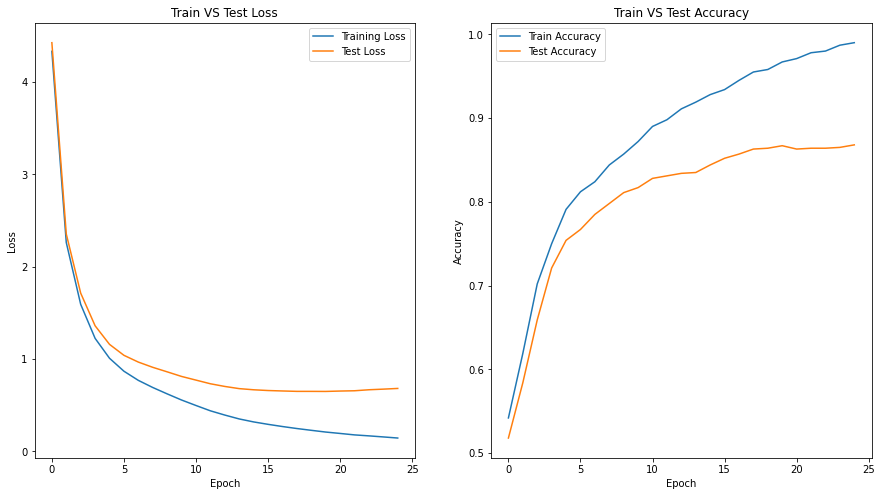

In [9]:
# train the model
my_model.trainer(train_input, train_target,train_classes, test_input, test_target,test_classes)

In [15]:
# output the total number of parameters
print("The total number of the parameters is: %d" % (sum(p.numel() for p in my_model.parameters())))

The total number of the parameters is: 146316


Epoch: 001/025 | Batch 000/1000 | Loss: 11.162423
Epoch: 001/025 | Batch 050/1000 | Loss: 8.067561
Epoch: 001/025 | Batch 100/1000 | Loss: 7.777165
Epoch: 001/025 | Batch 150/1000 | Loss: 7.188302
Epoch: 001/025 | Batch 200/1000 | Loss: 5.467725
Epoch: 001/025 | Batch 250/1000 | Loss: 6.034854
Epoch: 001/025 | Batch 300/1000 | Loss: 5.300813
Epoch: 001/025 | Batch 350/1000 | Loss: 5.245306
Epoch: 001/025 | Batch 400/1000 | Loss: 5.262438
Epoch: 001/025 | Batch 450/1000 | Loss: 4.880387
Epoch: 001/025 | Batch 500/1000 | Loss: 4.569422
Epoch: 001/025 | Batch 550/1000 | Loss: 4.904845
Epoch: 001/025 | Batch 600/1000 | Loss: 4.391887
Epoch: 001/025 | Batch 650/1000 | Loss: 3.475495
Epoch: 001/025 | Batch 700/1000 | Loss: 3.752621
Epoch: 001/025 | Batch 750/1000 | Loss: 3.551797
Epoch: 001/025 | Batch 800/1000 | Loss: 3.288620
Epoch: 001/025 | Batch 850/1000 | Loss: 3.636679
Epoch: 001/025 | Batch 900/1000 | Loss: 2.996027
Epoch: 001/025 | Batch 950/1000 | Loss: 2.736302
Time elapsed: 0.02 

Epoch: 009/025 | Batch 300/1000 | Loss: 0.692617
Epoch: 009/025 | Batch 350/1000 | Loss: 0.593101
Epoch: 009/025 | Batch 400/1000 | Loss: 0.498984
Epoch: 009/025 | Batch 450/1000 | Loss: 0.708587
Epoch: 009/025 | Batch 500/1000 | Loss: 0.485938
Epoch: 009/025 | Batch 550/1000 | Loss: 0.743740
Epoch: 009/025 | Batch 600/1000 | Loss: 0.665387
Epoch: 009/025 | Batch 650/1000 | Loss: 0.642389
Epoch: 009/025 | Batch 700/1000 | Loss: 0.465508
Epoch: 009/025 | Batch 750/1000 | Loss: 0.611755
Epoch: 009/025 | Batch 800/1000 | Loss: 0.561062
Epoch: 009/025 | Batch 850/1000 | Loss: 0.621458
Epoch: 009/025 | Batch 900/1000 | Loss: 0.707411
Epoch: 009/025 | Batch 950/1000 | Loss: 0.460046
Time elapsed: 0.18 min
Epoch: 010/025 | Batch 000/1000 | Loss: 0.543824
Epoch: 010/025 | Batch 050/1000 | Loss: 0.468415
Epoch: 010/025 | Batch 100/1000 | Loss: 0.486116
Epoch: 010/025 | Batch 150/1000 | Loss: 0.633832
Epoch: 010/025 | Batch 200/1000 | Loss: 0.731209
Epoch: 010/025 | Batch 250/1000 | Loss: 0.4351

Epoch: 017/025 | Batch 750/1000 | Loss: 0.379676
Epoch: 017/025 | Batch 800/1000 | Loss: 0.288774
Epoch: 017/025 | Batch 850/1000 | Loss: 0.329367
Epoch: 017/025 | Batch 900/1000 | Loss: 0.366363
Epoch: 017/025 | Batch 950/1000 | Loss: 0.187072
Time elapsed: 0.35 min
Epoch: 018/025 | Batch 000/1000 | Loss: 0.247221
Epoch: 018/025 | Batch 050/1000 | Loss: 0.243784
Epoch: 018/025 | Batch 100/1000 | Loss: 0.198729
Epoch: 018/025 | Batch 150/1000 | Loss: 0.300767
Epoch: 018/025 | Batch 200/1000 | Loss: 0.318663
Epoch: 018/025 | Batch 250/1000 | Loss: 0.211723
Epoch: 018/025 | Batch 300/1000 | Loss: 0.294717
Epoch: 018/025 | Batch 350/1000 | Loss: 0.255353
Epoch: 018/025 | Batch 400/1000 | Loss: 0.235822
Epoch: 018/025 | Batch 450/1000 | Loss: 0.302080
Epoch: 018/025 | Batch 500/1000 | Loss: 0.181522
Epoch: 018/025 | Batch 550/1000 | Loss: 0.267285
Epoch: 018/025 | Batch 600/1000 | Loss: 0.231874
Epoch: 018/025 | Batch 650/1000 | Loss: 0.267252
Epoch: 018/025 | Batch 700/1000 | Loss: 0.1662

Time elapsed: 0.50 min
Total Training Time: 0.50 min
Epoch: 001/025 | Batch 000/1000 | Loss: 13.713542
Epoch: 001/025 | Batch 050/1000 | Loss: 8.976967
Epoch: 001/025 | Batch 100/1000 | Loss: 8.060287
Epoch: 001/025 | Batch 150/1000 | Loss: 6.589848
Epoch: 001/025 | Batch 200/1000 | Loss: 6.919727
Epoch: 001/025 | Batch 250/1000 | Loss: 6.392565
Epoch: 001/025 | Batch 300/1000 | Loss: 5.818774
Epoch: 001/025 | Batch 350/1000 | Loss: 5.311162
Epoch: 001/025 | Batch 400/1000 | Loss: 5.418373
Epoch: 001/025 | Batch 450/1000 | Loss: 5.062602
Epoch: 001/025 | Batch 500/1000 | Loss: 4.516538
Epoch: 001/025 | Batch 550/1000 | Loss: 4.441550
Epoch: 001/025 | Batch 600/1000 | Loss: 4.102928
Epoch: 001/025 | Batch 650/1000 | Loss: 3.580669
Epoch: 001/025 | Batch 700/1000 | Loss: 3.369329
Epoch: 001/025 | Batch 750/1000 | Loss: 2.760295
Epoch: 001/025 | Batch 800/1000 | Loss: 2.680511
Epoch: 001/025 | Batch 850/1000 | Loss: 3.211127
Epoch: 001/025 | Batch 900/1000 | Loss: 3.495210
Epoch: 001/025 

Epoch: 009/025 | Batch 350/1000 | Loss: 0.711069
Epoch: 009/025 | Batch 400/1000 | Loss: 0.645933
Epoch: 009/025 | Batch 450/1000 | Loss: 0.718678
Epoch: 009/025 | Batch 500/1000 | Loss: 0.743039
Epoch: 009/025 | Batch 550/1000 | Loss: 0.587016
Epoch: 009/025 | Batch 600/1000 | Loss: 0.683691
Epoch: 009/025 | Batch 650/1000 | Loss: 0.762031
Epoch: 009/025 | Batch 700/1000 | Loss: 0.600746
Epoch: 009/025 | Batch 750/1000 | Loss: 0.564912
Epoch: 009/025 | Batch 800/1000 | Loss: 0.447731
Epoch: 009/025 | Batch 850/1000 | Loss: 0.617438
Epoch: 009/025 | Batch 900/1000 | Loss: 0.720640
Epoch: 009/025 | Batch 950/1000 | Loss: 0.687499
Time elapsed: 0.16 min
Epoch: 010/025 | Batch 000/1000 | Loss: 0.638232
Epoch: 010/025 | Batch 050/1000 | Loss: 0.504529
Epoch: 010/025 | Batch 100/1000 | Loss: 0.679334
Epoch: 010/025 | Batch 150/1000 | Loss: 0.551098
Epoch: 010/025 | Batch 200/1000 | Loss: 0.498880
Epoch: 010/025 | Batch 250/1000 | Loss: 0.536112
Epoch: 010/025 | Batch 300/1000 | Loss: 0.7353

Epoch: 017/025 | Batch 650/1000 | Loss: 0.422688
Epoch: 017/025 | Batch 700/1000 | Loss: 0.327900
Epoch: 017/025 | Batch 750/1000 | Loss: 0.223071
Epoch: 017/025 | Batch 800/1000 | Loss: 0.189669
Epoch: 017/025 | Batch 850/1000 | Loss: 0.234260
Epoch: 017/025 | Batch 900/1000 | Loss: 0.351212
Epoch: 017/025 | Batch 950/1000 | Loss: 0.259246
Time elapsed: 0.30 min
Epoch: 018/025 | Batch 000/1000 | Loss: 0.346517
Epoch: 018/025 | Batch 050/1000 | Loss: 0.220252
Epoch: 018/025 | Batch 100/1000 | Loss: 0.281693
Epoch: 018/025 | Batch 150/1000 | Loss: 0.273636
Epoch: 018/025 | Batch 200/1000 | Loss: 0.228090
Epoch: 018/025 | Batch 250/1000 | Loss: 0.239774
Epoch: 018/025 | Batch 300/1000 | Loss: 0.346942
Epoch: 018/025 | Batch 350/1000 | Loss: 0.274308
Epoch: 018/025 | Batch 400/1000 | Loss: 0.295312
Epoch: 018/025 | Batch 450/1000 | Loss: 0.295749
Epoch: 018/025 | Batch 500/1000 | Loss: 0.359483
Epoch: 018/025 | Batch 550/1000 | Loss: 0.193089
Epoch: 018/025 | Batch 600/1000 | Loss: 0.2290

Epoch: 025/025 | Batch 950/1000 | Loss: 0.090554
Time elapsed: 0.49 min
Total Training Time: 0.49 min
Epoch: 001/025 | Batch 000/1000 | Loss: 7.084169
Epoch: 001/025 | Batch 050/1000 | Loss: 5.770042
Epoch: 001/025 | Batch 100/1000 | Loss: 5.331789
Epoch: 001/025 | Batch 150/1000 | Loss: 4.956780
Epoch: 001/025 | Batch 200/1000 | Loss: 4.832740
Epoch: 001/025 | Batch 250/1000 | Loss: 4.332694
Epoch: 001/025 | Batch 300/1000 | Loss: 4.236862
Epoch: 001/025 | Batch 350/1000 | Loss: 3.932972
Epoch: 001/025 | Batch 400/1000 | Loss: 3.842035
Epoch: 001/025 | Batch 450/1000 | Loss: 3.279320
Epoch: 001/025 | Batch 500/1000 | Loss: 3.044982
Epoch: 001/025 | Batch 550/1000 | Loss: 3.614064
Epoch: 001/025 | Batch 600/1000 | Loss: 3.569518
Epoch: 001/025 | Batch 650/1000 | Loss: 2.997084
Epoch: 001/025 | Batch 700/1000 | Loss: 2.959480
Epoch: 001/025 | Batch 750/1000 | Loss: 3.085911
Epoch: 001/025 | Batch 800/1000 | Loss: 2.971615
Epoch: 001/025 | Batch 850/1000 | Loss: 2.730464
Epoch: 001/025 |

Epoch: 009/025 | Batch 250/1000 | Loss: 0.698336
Epoch: 009/025 | Batch 300/1000 | Loss: 0.556820
Epoch: 009/025 | Batch 350/1000 | Loss: 0.622381
Epoch: 009/025 | Batch 400/1000 | Loss: 0.618697
Epoch: 009/025 | Batch 450/1000 | Loss: 0.674572
Epoch: 009/025 | Batch 500/1000 | Loss: 0.589661
Epoch: 009/025 | Batch 550/1000 | Loss: 0.542797
Epoch: 009/025 | Batch 600/1000 | Loss: 0.649792
Epoch: 009/025 | Batch 650/1000 | Loss: 0.608730
Epoch: 009/025 | Batch 700/1000 | Loss: 0.543273
Epoch: 009/025 | Batch 750/1000 | Loss: 0.646903
Epoch: 009/025 | Batch 800/1000 | Loss: 0.768282
Epoch: 009/025 | Batch 850/1000 | Loss: 0.610349
Epoch: 009/025 | Batch 900/1000 | Loss: 0.749694
Epoch: 009/025 | Batch 950/1000 | Loss: 0.506668
Time elapsed: 0.24 min
Epoch: 010/025 | Batch 000/1000 | Loss: 0.525029
Epoch: 010/025 | Batch 050/1000 | Loss: 0.670792
Epoch: 010/025 | Batch 100/1000 | Loss: 0.667047
Epoch: 010/025 | Batch 150/1000 | Loss: 0.465325
Epoch: 010/025 | Batch 200/1000 | Loss: 0.4543

Epoch: 017/025 | Batch 650/1000 | Loss: 0.253114
Epoch: 017/025 | Batch 700/1000 | Loss: 0.270858
Epoch: 017/025 | Batch 750/1000 | Loss: 0.319020
Epoch: 017/025 | Batch 800/1000 | Loss: 0.425668
Epoch: 017/025 | Batch 850/1000 | Loss: 0.273836
Epoch: 017/025 | Batch 900/1000 | Loss: 0.352613
Epoch: 017/025 | Batch 950/1000 | Loss: 0.172844
Time elapsed: 0.43 min
Epoch: 018/025 | Batch 000/1000 | Loss: 0.260701
Epoch: 018/025 | Batch 050/1000 | Loss: 0.229393
Epoch: 018/025 | Batch 100/1000 | Loss: 0.296290
Epoch: 018/025 | Batch 150/1000 | Loss: 0.191491
Epoch: 018/025 | Batch 200/1000 | Loss: 0.187110
Epoch: 018/025 | Batch 250/1000 | Loss: 0.303650
Epoch: 018/025 | Batch 300/1000 | Loss: 0.221885
Epoch: 018/025 | Batch 350/1000 | Loss: 0.241508
Epoch: 018/025 | Batch 400/1000 | Loss: 0.254261
Epoch: 018/025 | Batch 450/1000 | Loss: 0.241285
Epoch: 018/025 | Batch 500/1000 | Loss: 0.241710
Epoch: 018/025 | Batch 550/1000 | Loss: 0.182085
Epoch: 018/025 | Batch 600/1000 | Loss: 0.2022

Time elapsed: 0.63 min
Total Training Time: 0.63 min
Epoch: 001/025 | Batch 000/1000 | Loss: 12.149560
Epoch: 001/025 | Batch 050/1000 | Loss: 10.672302
Epoch: 001/025 | Batch 100/1000 | Loss: 7.930117
Epoch: 001/025 | Batch 150/1000 | Loss: 7.662097
Epoch: 001/025 | Batch 200/1000 | Loss: 6.650960
Epoch: 001/025 | Batch 250/1000 | Loss: 6.148277
Epoch: 001/025 | Batch 300/1000 | Loss: 5.730880
Epoch: 001/025 | Batch 350/1000 | Loss: 5.349897
Epoch: 001/025 | Batch 400/1000 | Loss: 5.506251
Epoch: 001/025 | Batch 450/1000 | Loss: 4.232218
Epoch: 001/025 | Batch 500/1000 | Loss: 5.012975
Epoch: 001/025 | Batch 550/1000 | Loss: 3.881680
Epoch: 001/025 | Batch 600/1000 | Loss: 3.627048
Epoch: 001/025 | Batch 650/1000 | Loss: 3.400228
Epoch: 001/025 | Batch 700/1000 | Loss: 3.633781
Epoch: 001/025 | Batch 750/1000 | Loss: 3.602024
Epoch: 001/025 | Batch 800/1000 | Loss: 3.206292
Epoch: 001/025 | Batch 850/1000 | Loss: 3.129069
Epoch: 001/025 | Batch 900/1000 | Loss: 3.006365
Epoch: 001/025

Epoch: 009/025 | Batch 250/1000 | Loss: 0.633503
Epoch: 009/025 | Batch 300/1000 | Loss: 0.454138
Epoch: 009/025 | Batch 350/1000 | Loss: 0.835925
Epoch: 009/025 | Batch 400/1000 | Loss: 0.687935
Epoch: 009/025 | Batch 450/1000 | Loss: 0.433152
Epoch: 009/025 | Batch 500/1000 | Loss: 0.795184
Epoch: 009/025 | Batch 550/1000 | Loss: 0.555905
Epoch: 009/025 | Batch 600/1000 | Loss: 0.572303
Epoch: 009/025 | Batch 650/1000 | Loss: 0.514420
Epoch: 009/025 | Batch 700/1000 | Loss: 0.580839
Epoch: 009/025 | Batch 750/1000 | Loss: 0.568442
Epoch: 009/025 | Batch 800/1000 | Loss: 0.547834
Epoch: 009/025 | Batch 850/1000 | Loss: 0.608285
Epoch: 009/025 | Batch 900/1000 | Loss: 0.530630
Epoch: 009/025 | Batch 950/1000 | Loss: 0.708224
Time elapsed: 0.20 min
Epoch: 010/025 | Batch 000/1000 | Loss: 0.604383
Epoch: 010/025 | Batch 050/1000 | Loss: 0.561619
Epoch: 010/025 | Batch 100/1000 | Loss: 0.475538
Epoch: 010/025 | Batch 150/1000 | Loss: 0.549014
Epoch: 010/025 | Batch 200/1000 | Loss: 0.5675

Epoch: 017/025 | Batch 600/1000 | Loss: 0.293166
Epoch: 017/025 | Batch 650/1000 | Loss: 0.262517
Epoch: 017/025 | Batch 700/1000 | Loss: 0.257552
Epoch: 017/025 | Batch 750/1000 | Loss: 0.287293
Epoch: 017/025 | Batch 800/1000 | Loss: 0.223936
Epoch: 017/025 | Batch 850/1000 | Loss: 0.315495
Epoch: 017/025 | Batch 900/1000 | Loss: 0.309229
Epoch: 017/025 | Batch 950/1000 | Loss: 0.277151
Time elapsed: 0.38 min
Epoch: 018/025 | Batch 000/1000 | Loss: 0.288350
Epoch: 018/025 | Batch 050/1000 | Loss: 0.231833
Epoch: 018/025 | Batch 100/1000 | Loss: 0.202341
Epoch: 018/025 | Batch 150/1000 | Loss: 0.261033
Epoch: 018/025 | Batch 200/1000 | Loss: 0.283515
Epoch: 018/025 | Batch 250/1000 | Loss: 0.210959
Epoch: 018/025 | Batch 300/1000 | Loss: 0.190706
Epoch: 018/025 | Batch 350/1000 | Loss: 0.413544
Epoch: 018/025 | Batch 400/1000 | Loss: 0.276194
Epoch: 018/025 | Batch 450/1000 | Loss: 0.120308
Epoch: 018/025 | Batch 500/1000 | Loss: 0.274271
Epoch: 018/025 | Batch 550/1000 | Loss: 0.1998

Time elapsed: 0.55 min
Total Training Time: 0.55 min
Epoch: 001/025 | Batch 000/1000 | Loss: 11.143162
Epoch: 001/025 | Batch 050/1000 | Loss: 10.072369
Epoch: 001/025 | Batch 100/1000 | Loss: 6.815220
Epoch: 001/025 | Batch 150/1000 | Loss: 6.983174
Epoch: 001/025 | Batch 200/1000 | Loss: 5.878091
Epoch: 001/025 | Batch 250/1000 | Loss: 6.021430
Epoch: 001/025 | Batch 300/1000 | Loss: 4.955498
Epoch: 001/025 | Batch 350/1000 | Loss: 4.663203
Epoch: 001/025 | Batch 400/1000 | Loss: 4.289317
Epoch: 001/025 | Batch 450/1000 | Loss: 4.354359
Epoch: 001/025 | Batch 500/1000 | Loss: 3.817290
Epoch: 001/025 | Batch 550/1000 | Loss: 3.364906
Epoch: 001/025 | Batch 600/1000 | Loss: 3.417947
Epoch: 001/025 | Batch 650/1000 | Loss: 3.759625
Epoch: 001/025 | Batch 700/1000 | Loss: 3.084055
Epoch: 001/025 | Batch 750/1000 | Loss: 3.277991
Epoch: 001/025 | Batch 800/1000 | Loss: 3.105202
Epoch: 001/025 | Batch 850/1000 | Loss: 2.955766
Epoch: 001/025 | Batch 900/1000 | Loss: 2.985501
Epoch: 001/025

Epoch: 009/025 | Batch 300/1000 | Loss: 0.603068
Epoch: 009/025 | Batch 350/1000 | Loss: 0.550700
Epoch: 009/025 | Batch 400/1000 | Loss: 0.611551
Epoch: 009/025 | Batch 450/1000 | Loss: 0.585066
Epoch: 009/025 | Batch 500/1000 | Loss: 0.559944
Epoch: 009/025 | Batch 550/1000 | Loss: 0.587703
Epoch: 009/025 | Batch 600/1000 | Loss: 0.466007
Epoch: 009/025 | Batch 650/1000 | Loss: 0.565935
Epoch: 009/025 | Batch 700/1000 | Loss: 0.821260
Epoch: 009/025 | Batch 750/1000 | Loss: 0.570597
Epoch: 009/025 | Batch 800/1000 | Loss: 0.549858
Epoch: 009/025 | Batch 850/1000 | Loss: 0.419909
Epoch: 009/025 | Batch 900/1000 | Loss: 0.526137
Epoch: 009/025 | Batch 950/1000 | Loss: 0.687017
Time elapsed: 0.19 min
Epoch: 010/025 | Batch 000/1000 | Loss: 0.482232
Epoch: 010/025 | Batch 050/1000 | Loss: 0.598749
Epoch: 010/025 | Batch 100/1000 | Loss: 0.629397
Epoch: 010/025 | Batch 150/1000 | Loss: 0.558905
Epoch: 010/025 | Batch 200/1000 | Loss: 0.539304
Epoch: 010/025 | Batch 250/1000 | Loss: 0.4334

Epoch: 017/025 | Batch 750/1000 | Loss: 0.242523
Epoch: 017/025 | Batch 800/1000 | Loss: 0.244567
Epoch: 017/025 | Batch 850/1000 | Loss: 0.155396
Epoch: 017/025 | Batch 900/1000 | Loss: 0.241522
Epoch: 017/025 | Batch 950/1000 | Loss: 0.284119
Time elapsed: 0.35 min
Epoch: 018/025 | Batch 000/1000 | Loss: 0.177641
Epoch: 018/025 | Batch 050/1000 | Loss: 0.202714
Epoch: 018/025 | Batch 100/1000 | Loss: 0.251457
Epoch: 018/025 | Batch 150/1000 | Loss: 0.167291
Epoch: 018/025 | Batch 200/1000 | Loss: 0.205092
Epoch: 018/025 | Batch 250/1000 | Loss: 0.151702
Epoch: 018/025 | Batch 300/1000 | Loss: 0.224766
Epoch: 018/025 | Batch 350/1000 | Loss: 0.183681
Epoch: 018/025 | Batch 400/1000 | Loss: 0.154960
Epoch: 018/025 | Batch 450/1000 | Loss: 0.219952
Epoch: 018/025 | Batch 500/1000 | Loss: 0.234672
Epoch: 018/025 | Batch 550/1000 | Loss: 0.189285
Epoch: 018/025 | Batch 600/1000 | Loss: 0.139221
Epoch: 018/025 | Batch 650/1000 | Loss: 0.180667
Epoch: 018/025 | Batch 700/1000 | Loss: 0.3341

Time elapsed: 0.54 min
Total Training Time: 0.54 min
Epoch: 001/025 | Batch 000/1000 | Loss: 18.051750
Epoch: 001/025 | Batch 050/1000 | Loss: 12.775735
Epoch: 001/025 | Batch 100/1000 | Loss: 11.226402
Epoch: 001/025 | Batch 150/1000 | Loss: 7.719846
Epoch: 001/025 | Batch 200/1000 | Loss: 7.971422
Epoch: 001/025 | Batch 250/1000 | Loss: 8.001097
Epoch: 001/025 | Batch 300/1000 | Loss: 6.350656
Epoch: 001/025 | Batch 350/1000 | Loss: 6.975531
Epoch: 001/025 | Batch 400/1000 | Loss: 6.186101
Epoch: 001/025 | Batch 450/1000 | Loss: 6.036551
Epoch: 001/025 | Batch 500/1000 | Loss: 5.727928
Epoch: 001/025 | Batch 550/1000 | Loss: 5.576246
Epoch: 001/025 | Batch 600/1000 | Loss: 5.058502
Epoch: 001/025 | Batch 650/1000 | Loss: 4.621024
Epoch: 001/025 | Batch 700/1000 | Loss: 4.937333
Epoch: 001/025 | Batch 750/1000 | Loss: 4.250776
Epoch: 001/025 | Batch 800/1000 | Loss: 4.123280
Epoch: 001/025 | Batch 850/1000 | Loss: 3.774858
Epoch: 001/025 | Batch 900/1000 | Loss: 3.960178
Epoch: 001/02

Epoch: 009/025 | Batch 300/1000 | Loss: 0.674768
Epoch: 009/025 | Batch 350/1000 | Loss: 0.586058
Epoch: 009/025 | Batch 400/1000 | Loss: 0.790038
Epoch: 009/025 | Batch 450/1000 | Loss: 0.548289
Epoch: 009/025 | Batch 500/1000 | Loss: 0.566586
Epoch: 009/025 | Batch 550/1000 | Loss: 0.684810
Epoch: 009/025 | Batch 600/1000 | Loss: 0.770131
Epoch: 009/025 | Batch 650/1000 | Loss: 0.855935
Epoch: 009/025 | Batch 700/1000 | Loss: 0.747920
Epoch: 009/025 | Batch 750/1000 | Loss: 0.552970
Epoch: 009/025 | Batch 800/1000 | Loss: 0.516946
Epoch: 009/025 | Batch 850/1000 | Loss: 0.754610
Epoch: 009/025 | Batch 900/1000 | Loss: 0.617045
Epoch: 009/025 | Batch 950/1000 | Loss: 0.838740
Time elapsed: 0.20 min
Epoch: 010/025 | Batch 000/1000 | Loss: 0.579611
Epoch: 010/025 | Batch 050/1000 | Loss: 0.514588
Epoch: 010/025 | Batch 100/1000 | Loss: 0.545679
Epoch: 010/025 | Batch 150/1000 | Loss: 0.532968
Epoch: 010/025 | Batch 200/1000 | Loss: 0.585546
Epoch: 010/025 | Batch 250/1000 | Loss: 0.7390

Epoch: 017/025 | Batch 650/1000 | Loss: 0.397915
Epoch: 017/025 | Batch 700/1000 | Loss: 0.312283
Epoch: 017/025 | Batch 750/1000 | Loss: 0.291020
Epoch: 017/025 | Batch 800/1000 | Loss: 0.246009
Epoch: 017/025 | Batch 850/1000 | Loss: 0.409421
Epoch: 017/025 | Batch 900/1000 | Loss: 0.227676
Epoch: 017/025 | Batch 950/1000 | Loss: 0.469833
Time elapsed: 0.37 min
Epoch: 018/025 | Batch 000/1000 | Loss: 0.271740
Epoch: 018/025 | Batch 050/1000 | Loss: 0.202862
Epoch: 018/025 | Batch 100/1000 | Loss: 0.239282
Epoch: 018/025 | Batch 150/1000 | Loss: 0.227566
Epoch: 018/025 | Batch 200/1000 | Loss: 0.250766
Epoch: 018/025 | Batch 250/1000 | Loss: 0.374701
Epoch: 018/025 | Batch 300/1000 | Loss: 0.235833
Epoch: 018/025 | Batch 350/1000 | Loss: 0.241765
Epoch: 018/025 | Batch 400/1000 | Loss: 0.300627
Epoch: 018/025 | Batch 450/1000 | Loss: 0.224311
Epoch: 018/025 | Batch 500/1000 | Loss: 0.236016
Epoch: 018/025 | Batch 550/1000 | Loss: 0.282304
Epoch: 018/025 | Batch 600/1000 | Loss: 0.3341

Time elapsed: 0.57 min
Total Training Time: 0.57 min
Epoch: 001/025 | Batch 000/1000 | Loss: 11.240991
Epoch: 001/025 | Batch 050/1000 | Loss: 7.621329
Epoch: 001/025 | Batch 100/1000 | Loss: 7.741791
Epoch: 001/025 | Batch 150/1000 | Loss: 6.987644
Epoch: 001/025 | Batch 200/1000 | Loss: 6.101855
Epoch: 001/025 | Batch 250/1000 | Loss: 5.128727
Epoch: 001/025 | Batch 300/1000 | Loss: 5.581717
Epoch: 001/025 | Batch 350/1000 | Loss: 5.171231
Epoch: 001/025 | Batch 400/1000 | Loss: 4.821719
Epoch: 001/025 | Batch 450/1000 | Loss: 5.077933
Epoch: 001/025 | Batch 500/1000 | Loss: 5.033666
Epoch: 001/025 | Batch 550/1000 | Loss: 4.506658
Epoch: 001/025 | Batch 600/1000 | Loss: 4.361203
Epoch: 001/025 | Batch 650/1000 | Loss: 4.062780
Epoch: 001/025 | Batch 700/1000 | Loss: 3.676208
Epoch: 001/025 | Batch 750/1000 | Loss: 3.760747
Epoch: 001/025 | Batch 800/1000 | Loss: 3.507670
Epoch: 001/025 | Batch 850/1000 | Loss: 3.246444
Epoch: 001/025 | Batch 900/1000 | Loss: 2.661417
Epoch: 001/025 

Epoch: 009/025 | Batch 300/1000 | Loss: 0.742038
Epoch: 009/025 | Batch 350/1000 | Loss: 0.672953
Epoch: 009/025 | Batch 400/1000 | Loss: 0.467988
Epoch: 009/025 | Batch 450/1000 | Loss: 0.551752
Epoch: 009/025 | Batch 500/1000 | Loss: 0.597158
Epoch: 009/025 | Batch 550/1000 | Loss: 0.571549
Epoch: 009/025 | Batch 600/1000 | Loss: 0.549395
Epoch: 009/025 | Batch 650/1000 | Loss: 0.521613
Epoch: 009/025 | Batch 700/1000 | Loss: 0.383917
Epoch: 009/025 | Batch 750/1000 | Loss: 0.496690
Epoch: 009/025 | Batch 800/1000 | Loss: 0.500331
Epoch: 009/025 | Batch 850/1000 | Loss: 0.522722
Epoch: 009/025 | Batch 900/1000 | Loss: 0.505637
Epoch: 009/025 | Batch 950/1000 | Loss: 0.562540
Time elapsed: 0.19 min
Epoch: 010/025 | Batch 000/1000 | Loss: 0.582871
Epoch: 010/025 | Batch 050/1000 | Loss: 0.537704
Epoch: 010/025 | Batch 100/1000 | Loss: 0.487517
Epoch: 010/025 | Batch 150/1000 | Loss: 0.647892
Epoch: 010/025 | Batch 200/1000 | Loss: 0.493216
Epoch: 010/025 | Batch 250/1000 | Loss: 0.3843

Epoch: 017/025 | Batch 600/1000 | Loss: 0.226527
Epoch: 017/025 | Batch 650/1000 | Loss: 0.231750
Epoch: 017/025 | Batch 700/1000 | Loss: 0.190377
Epoch: 017/025 | Batch 750/1000 | Loss: 0.292924
Epoch: 017/025 | Batch 800/1000 | Loss: 0.265128
Epoch: 017/025 | Batch 850/1000 | Loss: 0.245140
Epoch: 017/025 | Batch 900/1000 | Loss: 0.294665
Epoch: 017/025 | Batch 950/1000 | Loss: 0.194888
Time elapsed: 0.39 min
Epoch: 018/025 | Batch 000/1000 | Loss: 0.284096
Epoch: 018/025 | Batch 050/1000 | Loss: 0.163191
Epoch: 018/025 | Batch 100/1000 | Loss: 0.229452
Epoch: 018/025 | Batch 150/1000 | Loss: 0.286523
Epoch: 018/025 | Batch 200/1000 | Loss: 0.186167
Epoch: 018/025 | Batch 250/1000 | Loss: 0.166703
Epoch: 018/025 | Batch 300/1000 | Loss: 0.399462
Epoch: 018/025 | Batch 350/1000 | Loss: 0.370107
Epoch: 018/025 | Batch 400/1000 | Loss: 0.191213
Epoch: 018/025 | Batch 450/1000 | Loss: 0.270047
Epoch: 018/025 | Batch 500/1000 | Loss: 0.217397
Epoch: 018/025 | Batch 550/1000 | Loss: 0.2215

Time elapsed: 0.57 min
Total Training Time: 0.57 min
Epoch: 001/025 | Batch 000/1000 | Loss: 10.914057
Epoch: 001/025 | Batch 050/1000 | Loss: 9.477827
Epoch: 001/025 | Batch 100/1000 | Loss: 7.311675
Epoch: 001/025 | Batch 150/1000 | Loss: 6.299899
Epoch: 001/025 | Batch 200/1000 | Loss: 5.430133
Epoch: 001/025 | Batch 250/1000 | Loss: 5.890932
Epoch: 001/025 | Batch 300/1000 | Loss: 4.641598
Epoch: 001/025 | Batch 350/1000 | Loss: 4.198108
Epoch: 001/025 | Batch 400/1000 | Loss: 4.124978
Epoch: 001/025 | Batch 450/1000 | Loss: 4.265114
Epoch: 001/025 | Batch 500/1000 | Loss: 4.610052
Epoch: 001/025 | Batch 550/1000 | Loss: 3.893872
Epoch: 001/025 | Batch 600/1000 | Loss: 4.394078
Epoch: 001/025 | Batch 650/1000 | Loss: 4.347816
Epoch: 001/025 | Batch 700/1000 | Loss: 3.412532
Epoch: 001/025 | Batch 750/1000 | Loss: 3.022062
Epoch: 001/025 | Batch 800/1000 | Loss: 2.999701
Epoch: 001/025 | Batch 850/1000 | Loss: 2.756869
Epoch: 001/025 | Batch 900/1000 | Loss: 3.361902
Epoch: 001/025 

Epoch: 009/025 | Batch 300/1000 | Loss: 0.700956
Epoch: 009/025 | Batch 350/1000 | Loss: 0.652946
Epoch: 009/025 | Batch 400/1000 | Loss: 0.604579
Epoch: 009/025 | Batch 450/1000 | Loss: 0.560495
Epoch: 009/025 | Batch 500/1000 | Loss: 0.880362
Epoch: 009/025 | Batch 550/1000 | Loss: 0.634344
Epoch: 009/025 | Batch 600/1000 | Loss: 0.674518
Epoch: 009/025 | Batch 650/1000 | Loss: 0.823547
Epoch: 009/025 | Batch 700/1000 | Loss: 0.580219
Epoch: 009/025 | Batch 750/1000 | Loss: 0.547386
Epoch: 009/025 | Batch 800/1000 | Loss: 0.588068
Epoch: 009/025 | Batch 850/1000 | Loss: 0.470388
Epoch: 009/025 | Batch 900/1000 | Loss: 0.546209
Epoch: 009/025 | Batch 950/1000 | Loss: 0.730371
Time elapsed: 0.21 min
Epoch: 010/025 | Batch 000/1000 | Loss: 0.559416
Epoch: 010/025 | Batch 050/1000 | Loss: 0.572316
Epoch: 010/025 | Batch 100/1000 | Loss: 0.658586
Epoch: 010/025 | Batch 150/1000 | Loss: 0.531662
Epoch: 010/025 | Batch 200/1000 | Loss: 0.349448
Epoch: 010/025 | Batch 250/1000 | Loss: 0.6455

Epoch: 017/025 | Batch 550/1000 | Loss: 0.299776
Epoch: 017/025 | Batch 600/1000 | Loss: 0.312187
Epoch: 017/025 | Batch 650/1000 | Loss: 0.348956
Epoch: 017/025 | Batch 700/1000 | Loss: 0.226234
Epoch: 017/025 | Batch 750/1000 | Loss: 0.247135
Epoch: 017/025 | Batch 800/1000 | Loss: 0.267464
Epoch: 017/025 | Batch 850/1000 | Loss: 0.254133
Epoch: 017/025 | Batch 900/1000 | Loss: 0.233846
Epoch: 017/025 | Batch 950/1000 | Loss: 0.297683
Time elapsed: 0.39 min
Epoch: 018/025 | Batch 000/1000 | Loss: 0.194602
Epoch: 018/025 | Batch 050/1000 | Loss: 0.208798
Epoch: 018/025 | Batch 100/1000 | Loss: 0.301904
Epoch: 018/025 | Batch 150/1000 | Loss: 0.196261
Epoch: 018/025 | Batch 200/1000 | Loss: 0.156213
Epoch: 018/025 | Batch 250/1000 | Loss: 0.259631
Epoch: 018/025 | Batch 300/1000 | Loss: 0.289633
Epoch: 018/025 | Batch 350/1000 | Loss: 0.331498
Epoch: 018/025 | Batch 400/1000 | Loss: 0.218649
Epoch: 018/025 | Batch 450/1000 | Loss: 0.192177
Epoch: 018/025 | Batch 500/1000 | Loss: 0.4067

Time elapsed: 0.58 min
Total Training Time: 0.58 min
Epoch: 001/025 | Batch 000/1000 | Loss: 24.843983
Epoch: 001/025 | Batch 050/1000 | Loss: 17.768654
Epoch: 001/025 | Batch 100/1000 | Loss: 13.617846
Epoch: 001/025 | Batch 150/1000 | Loss: 11.498619
Epoch: 001/025 | Batch 200/1000 | Loss: 10.772463
Epoch: 001/025 | Batch 250/1000 | Loss: 9.748549
Epoch: 001/025 | Batch 300/1000 | Loss: 9.091874
Epoch: 001/025 | Batch 350/1000 | Loss: 8.729758
Epoch: 001/025 | Batch 400/1000 | Loss: 7.872516
Epoch: 001/025 | Batch 450/1000 | Loss: 7.211032
Epoch: 001/025 | Batch 500/1000 | Loss: 5.915150
Epoch: 001/025 | Batch 550/1000 | Loss: 6.007214
Epoch: 001/025 | Batch 600/1000 | Loss: 6.571091
Epoch: 001/025 | Batch 650/1000 | Loss: 6.213573
Epoch: 001/025 | Batch 700/1000 | Loss: 6.089228
Epoch: 001/025 | Batch 750/1000 | Loss: 5.866777
Epoch: 001/025 | Batch 800/1000 | Loss: 5.480241
Epoch: 001/025 | Batch 850/1000 | Loss: 4.952955
Epoch: 001/025 | Batch 900/1000 | Loss: 4.275875
Epoch: 001/

Epoch: 009/025 | Batch 300/1000 | Loss: 0.969169
Epoch: 009/025 | Batch 350/1000 | Loss: 0.681899
Epoch: 009/025 | Batch 400/1000 | Loss: 0.745794
Epoch: 009/025 | Batch 450/1000 | Loss: 0.736477
Epoch: 009/025 | Batch 500/1000 | Loss: 0.720398
Epoch: 009/025 | Batch 550/1000 | Loss: 0.820665
Epoch: 009/025 | Batch 600/1000 | Loss: 0.788945
Epoch: 009/025 | Batch 650/1000 | Loss: 1.035933
Epoch: 009/025 | Batch 700/1000 | Loss: 0.766582
Epoch: 009/025 | Batch 750/1000 | Loss: 0.566518
Epoch: 009/025 | Batch 800/1000 | Loss: 0.743813
Epoch: 009/025 | Batch 850/1000 | Loss: 0.959309
Epoch: 009/025 | Batch 900/1000 | Loss: 0.703143
Epoch: 009/025 | Batch 950/1000 | Loss: 0.757278
Time elapsed: 0.19 min
Epoch: 010/025 | Batch 000/1000 | Loss: 0.674147
Epoch: 010/025 | Batch 050/1000 | Loss: 0.827932
Epoch: 010/025 | Batch 100/1000 | Loss: 0.590212
Epoch: 010/025 | Batch 150/1000 | Loss: 0.489977
Epoch: 010/025 | Batch 200/1000 | Loss: 0.598761
Epoch: 010/025 | Batch 250/1000 | Loss: 0.7221

Epoch: 017/025 | Batch 650/1000 | Loss: 0.492330
Epoch: 017/025 | Batch 700/1000 | Loss: 0.374541
Epoch: 017/025 | Batch 750/1000 | Loss: 0.228157
Epoch: 017/025 | Batch 800/1000 | Loss: 0.405714
Epoch: 017/025 | Batch 850/1000 | Loss: 0.352300
Epoch: 017/025 | Batch 900/1000 | Loss: 0.292892
Epoch: 017/025 | Batch 950/1000 | Loss: 0.406461
Time elapsed: 0.36 min
Epoch: 018/025 | Batch 000/1000 | Loss: 0.393097
Epoch: 018/025 | Batch 050/1000 | Loss: 0.410131
Epoch: 018/025 | Batch 100/1000 | Loss: 0.286437
Epoch: 018/025 | Batch 150/1000 | Loss: 0.220434
Epoch: 018/025 | Batch 200/1000 | Loss: 0.353412
Epoch: 018/025 | Batch 250/1000 | Loss: 0.408040
Epoch: 018/025 | Batch 300/1000 | Loss: 0.430733
Epoch: 018/025 | Batch 350/1000 | Loss: 0.316766
Epoch: 018/025 | Batch 400/1000 | Loss: 0.290211
Epoch: 018/025 | Batch 450/1000 | Loss: 0.287432
Epoch: 018/025 | Batch 500/1000 | Loss: 0.299514
Epoch: 018/025 | Batch 550/1000 | Loss: 0.350293
Epoch: 018/025 | Batch 600/1000 | Loss: 0.3491

Epoch: 025/025 | Batch 900/1000 | Loss: 0.153492
Epoch: 025/025 | Batch 950/1000 | Loss: 0.316961
Time elapsed: 0.56 min
Total Training Time: 0.56 min
Epoch: 001/025 | Batch 000/1000 | Loss: 11.664454
Epoch: 001/025 | Batch 050/1000 | Loss: 9.937343
Epoch: 001/025 | Batch 100/1000 | Loss: 7.921355
Epoch: 001/025 | Batch 150/1000 | Loss: 6.152222
Epoch: 001/025 | Batch 200/1000 | Loss: 4.382933
Epoch: 001/025 | Batch 250/1000 | Loss: 4.344335
Epoch: 001/025 | Batch 300/1000 | Loss: 4.455223
Epoch: 001/025 | Batch 350/1000 | Loss: 4.132399
Epoch: 001/025 | Batch 400/1000 | Loss: 4.227523
Epoch: 001/025 | Batch 450/1000 | Loss: 4.787596
Epoch: 001/025 | Batch 500/1000 | Loss: 4.389024
Epoch: 001/025 | Batch 550/1000 | Loss: 4.056259
Epoch: 001/025 | Batch 600/1000 | Loss: 3.304141
Epoch: 001/025 | Batch 650/1000 | Loss: 3.243386
Epoch: 001/025 | Batch 700/1000 | Loss: 3.552890
Epoch: 001/025 | Batch 750/1000 | Loss: 3.256090
Epoch: 001/025 | Batch 800/1000 | Loss: 2.456696
Epoch: 001/025 

Epoch: 009/025 | Batch 300/1000 | Loss: 0.705605
Epoch: 009/025 | Batch 350/1000 | Loss: 0.680110
Epoch: 009/025 | Batch 400/1000 | Loss: 0.634795
Epoch: 009/025 | Batch 450/1000 | Loss: 0.490345
Epoch: 009/025 | Batch 500/1000 | Loss: 0.670411
Epoch: 009/025 | Batch 550/1000 | Loss: 0.642239
Epoch: 009/025 | Batch 600/1000 | Loss: 0.520228
Epoch: 009/025 | Batch 650/1000 | Loss: 0.543481
Epoch: 009/025 | Batch 700/1000 | Loss: 0.746531
Epoch: 009/025 | Batch 750/1000 | Loss: 0.646760
Epoch: 009/025 | Batch 800/1000 | Loss: 0.540330
Epoch: 009/025 | Batch 850/1000 | Loss: 0.544906
Epoch: 009/025 | Batch 900/1000 | Loss: 0.434221
Epoch: 009/025 | Batch 950/1000 | Loss: 0.482769
Time elapsed: 0.21 min
Epoch: 010/025 | Batch 000/1000 | Loss: 0.524828
Epoch: 010/025 | Batch 050/1000 | Loss: 0.507750
Epoch: 010/025 | Batch 100/1000 | Loss: 0.677329
Epoch: 010/025 | Batch 150/1000 | Loss: 0.424104
Epoch: 010/025 | Batch 200/1000 | Loss: 0.474718
Epoch: 010/025 | Batch 250/1000 | Loss: 0.4464

Epoch: 017/025 | Batch 550/1000 | Loss: 0.263537
Epoch: 017/025 | Batch 600/1000 | Loss: 0.172224
Epoch: 017/025 | Batch 650/1000 | Loss: 0.181275
Epoch: 017/025 | Batch 700/1000 | Loss: 0.340923
Epoch: 017/025 | Batch 750/1000 | Loss: 0.357116
Epoch: 017/025 | Batch 800/1000 | Loss: 0.209270
Epoch: 017/025 | Batch 850/1000 | Loss: 0.196932
Epoch: 017/025 | Batch 900/1000 | Loss: 0.126134
Epoch: 017/025 | Batch 950/1000 | Loss: 0.174191
Time elapsed: 0.40 min
Epoch: 018/025 | Batch 000/1000 | Loss: 0.194778
Epoch: 018/025 | Batch 050/1000 | Loss: 0.198265
Epoch: 018/025 | Batch 100/1000 | Loss: 0.251479
Epoch: 018/025 | Batch 150/1000 | Loss: 0.146390
Epoch: 018/025 | Batch 200/1000 | Loss: 0.177213
Epoch: 018/025 | Batch 250/1000 | Loss: 0.149229
Epoch: 018/025 | Batch 300/1000 | Loss: 0.298358
Epoch: 018/025 | Batch 350/1000 | Loss: 0.256330
Epoch: 018/025 | Batch 400/1000 | Loss: 0.248199
Epoch: 018/025 | Batch 450/1000 | Loss: 0.132210
Epoch: 018/025 | Batch 500/1000 | Loss: 0.1908

Epoch: 025/025 | Batch 950/1000 | Loss: 0.046169
Time elapsed: 0.62 min
Total Training Time: 0.62 min


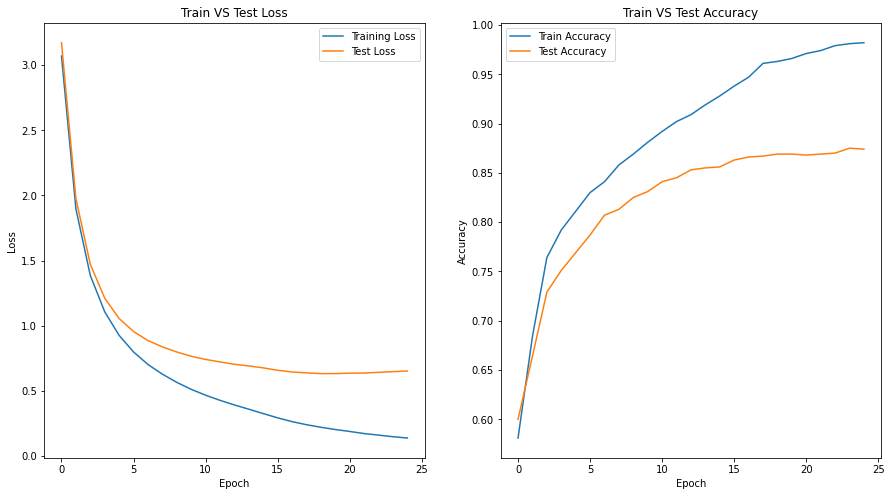

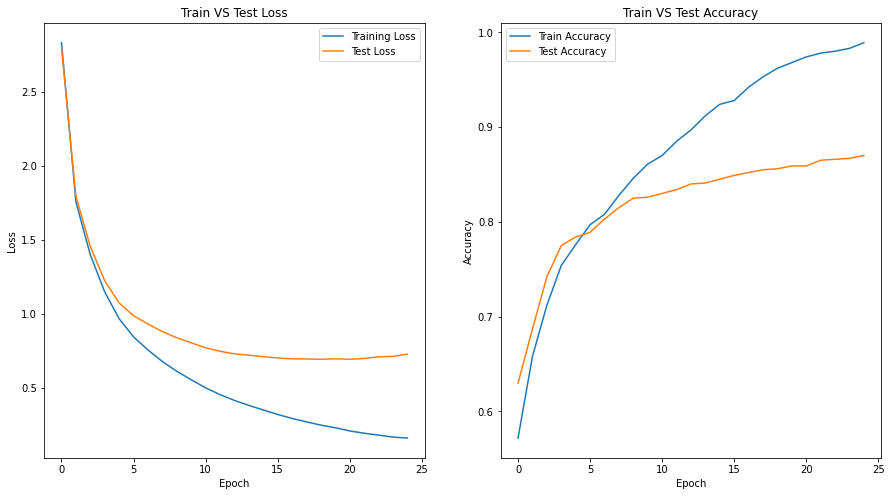

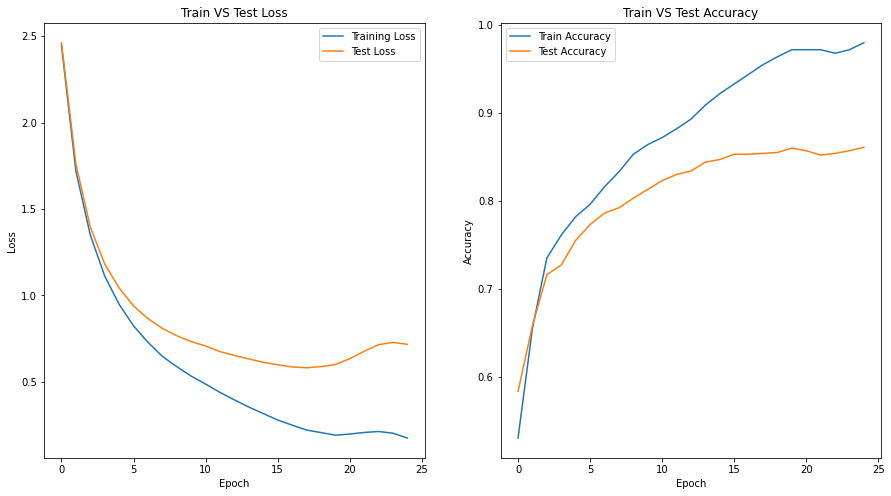

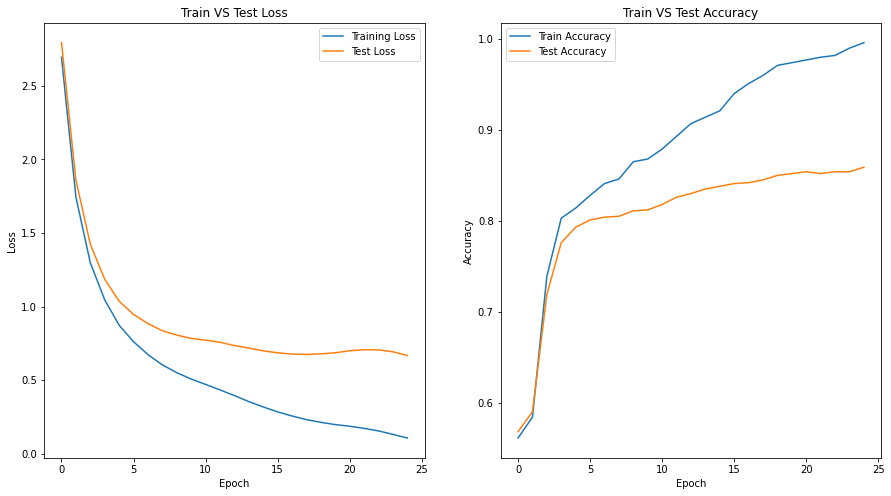

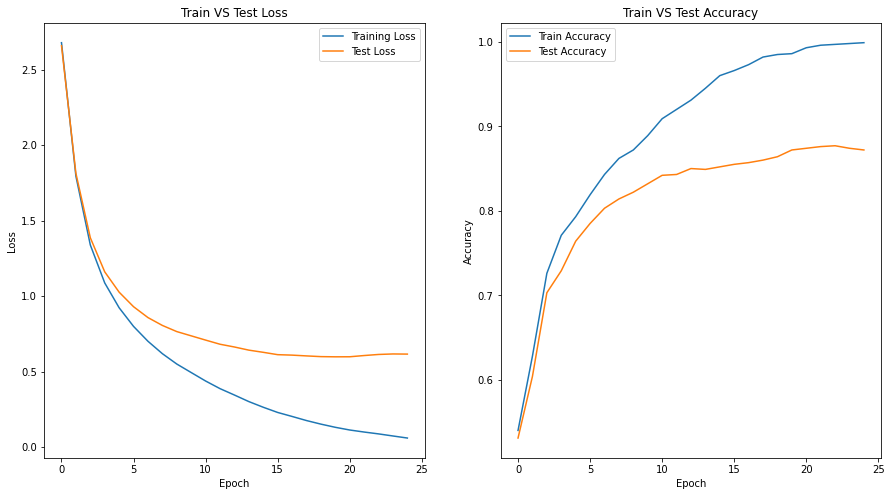

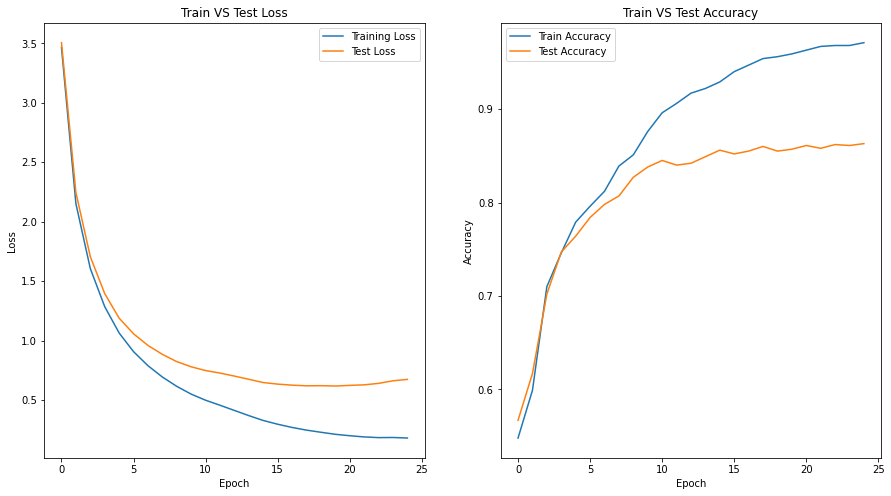

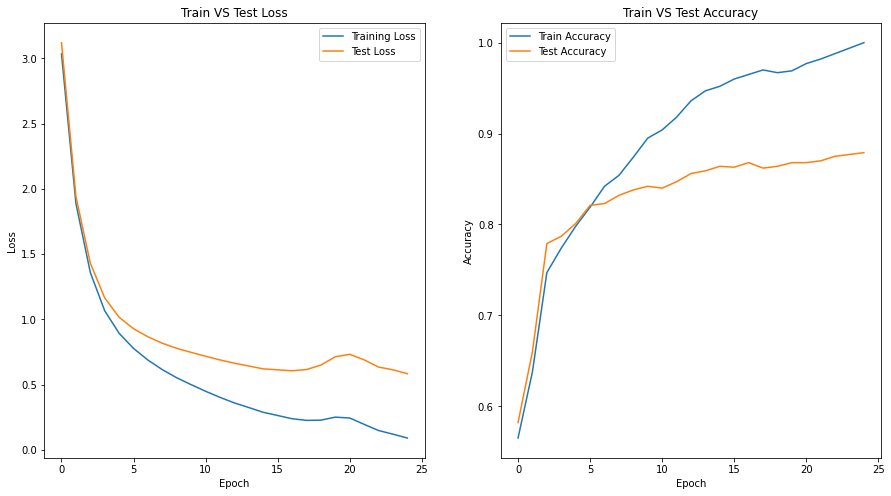

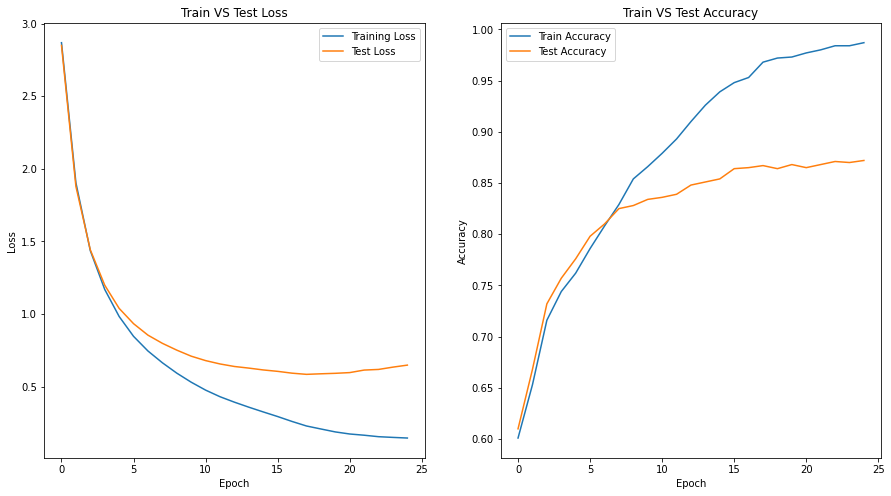

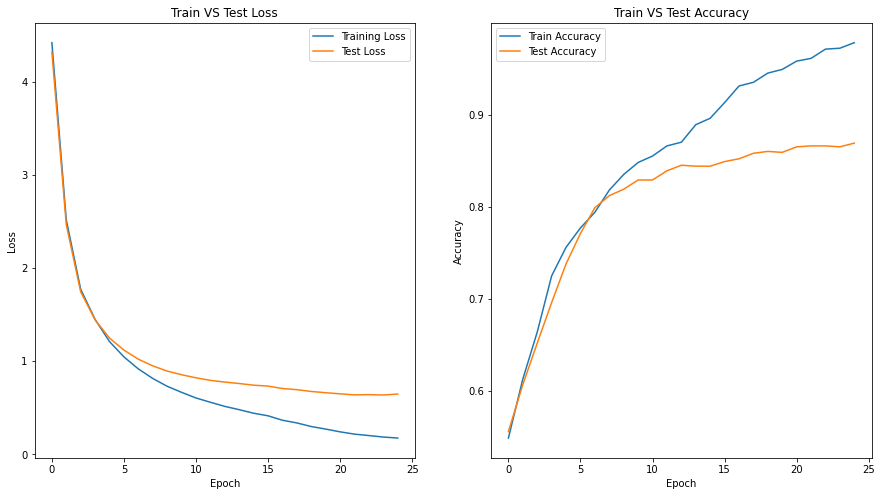

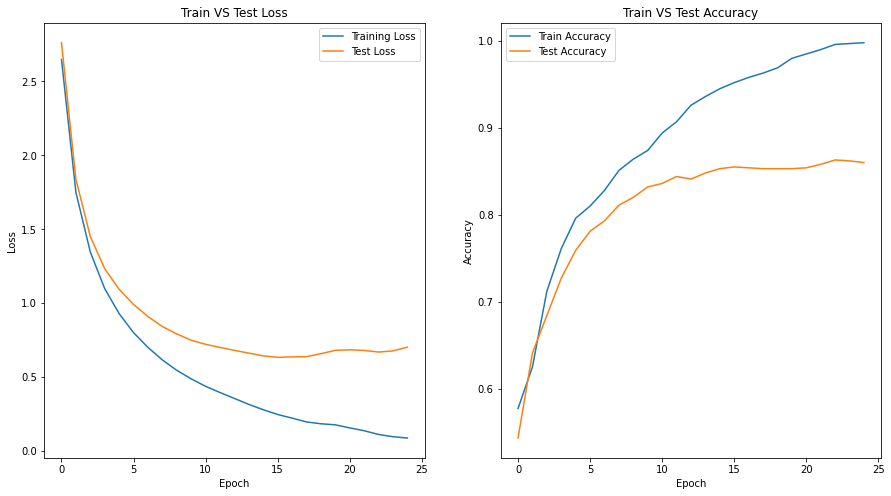

In [11]:
# calculate the standard deviation:
train_errors=[]
test_errors=[]
for num in range(10):
    N_PAIRS = 1000
    train_input, train_target, train_classes, test_input, test_target, test_classes = prologue.generate_pair_sets(N_PAIRS)
    my_model = CNN_Net_weight_sharing_auxiliary_loss()
    # train the model
    my_model.trainer(train_input, train_target,train_classes, test_input, test_target, test_classes)
    train_errors.append(my_model.compute_error(train_input, train_target))
    test_errors.append(my_model.compute_error(test_input, test_target))

In [16]:
# print out the deviation and mean value of the training and testing errors
print('The standard deviation of train error:',np.std(train_errors))
print('The standard deviation of test error:',np.std(test_errors))
print('The mean of train error:',np.mean(train_errors))
print('The mean of test error:',np.mean(test_errors))

The standard deviation of train error: 0.009591664463477033
The standard deviation of test error: 0.006425726111108515
The mean of train error: 0.01199999451637268
The mean of test error: 0.13209999799728395


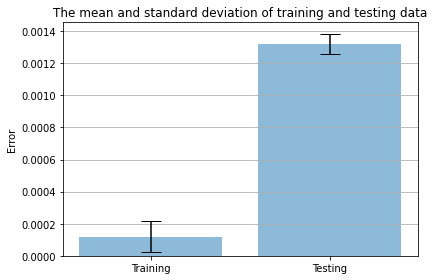

In [17]:
#plot the standard 
# Define labels, positions, bar heights and error bar heights
labels = ['Training', 'Testing']
x_pos = np.arange(len(labels))
means = [np.mean(train_errors)/100, np.mean(test_errors)/100]
stds = [np.std(np.divide(train_errors, 100)), np.std(np.divide(test_errors, 100))]
# Build the plot
fig, ax = plt.subplots()
ax.bar(x_pos, means,
       yerr=stds,
       align='center',
       alpha=0.5,
       ecolor='black',
       capsize=10)
ax.set_ylabel('Error')
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
ax.set_title('The mean and standard deviation of training and testing data')
ax.yaxis.grid(True)

# show the plot
plt.tight_layout()
plt.show()